# **CONTRASTIVE LEARNING OF GENERAL-PURPOSE AUDIO REPRESENTATIONS**

In [1]:
import torch
torch.cuda.is_available()

True



## 1. Data preparation : Pre-compute mel-spectrograms and save them as .npy




C:\Users\idris\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


C:\Users\idris
C:\Users\idris\M2CNS\AP\Projet\BallroomData
698


Progress of saving npy files: 100%|██████████| 698/698 [09:11<00:00,  1.27it/s]


(938, 64) -1.0 1.0
0.896588486140725


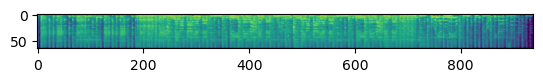

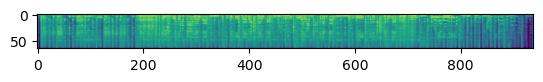

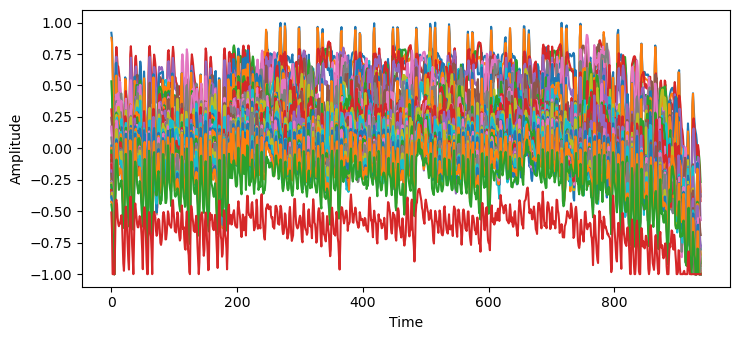

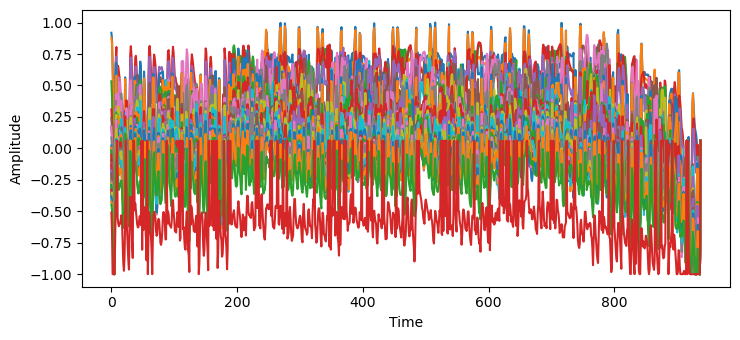

-1.0 1.0
[[ 0.918964    0.8789713   0.53330487 ... -0.42583436 -0.4462183
  -0.50984514]
 [ 0.8765632   0.84000456  0.41422278 ... -0.43852407 -0.49082032
  -0.6541874 ]
 [ 0.6506069   0.5851377   0.12163286 ... -0.5473321  -0.6511795
  -1.        ]
 ...
 [-0.17772198 -0.14155388 -0.07217503 ... -1.         -1.
  -1.        ]
 [-0.24494667 -0.21579513 -0.14482002 ... -1.         -1.
  -1.        ]
 [-0.38273278 -0.3457389  -0.26761475 ... -1.         -1.
  -1.        ]]


In [2]:
import random

import librosa
import numpy as np

from tqdm import tqdm
from glob import glob
from multiprocessing import Pool
from pathlib import Path
import matplotlib.pyplot as plt

import warnings
from cryptography.utils import CryptographyDeprecationWarning
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=CryptographyDeprecationWarning)
    import paramiko

input_length = 16000 * 30

n_mels = 64


def pre_process_audio_mel_t(audio, sample_rate=16000):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels)
    mel_db = (librosa.power_to_db(mel_spec, ref=np.max) + 40) / 40

    return mel_db.T


def load_audio_file(file_path, input_length=input_length):
    try:
        data = librosa.core.load(file_path, sr=16000)[0]  # , sr=16000
    except ZeroDivisionError:
        data = []

    if len(data) > input_length:

        max_offset = len(data) - input_length

        offset = np.random.randint(max_offset)

        data = data[offset : (input_length + offset)]

    else:
        if input_length > len(data):
            max_offset = input_length - len(data)

            offset = np.random.randint(max_offset)
        else:
            offset = 0

        data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

    data = pre_process_audio_mel_t(data)
    return data


def random_crop(data, crop_size=128):
    start = int(random.random() * (data.shape[0] - crop_size))
    return data[start : (start + crop_size), :]


def random_mask(data, rate_start=0.1, rate_seq=0.2):
    new_data = data.copy()
    mean = new_data.mean()
    prev_zero = False
    for i in range(new_data.shape[0]):
        if random.random() < rate_start or (
            prev_zero and random.random() < rate_seq
        ):
            prev_zero = True
            new_data[i, :] = mean
        else:
            prev_zero = False

    return new_data


def random_multiply(data):
    new_data = data.copy()
    return new_data * (0.9 + random.random() / 5.)


def save(path):
    data = load_audio_file(path)
    np.save(str(path).replace(".wav", ".npy"), data)
    return True


home = Path.home()
print(home)
base_path = Path(home, "M2CNS", "AP","Projet","BallroomData")
print(base_path)

files = sorted(list(glob(str(base_path / "*/*.wav"))))

print(len(files))

for f in tqdm(files, total=len(files), desc="Progress of saving npy files"):
    b = save(f)

data = load_audio_file(files[0], input_length=16000 * 30)

print(data.shape, np.min(data), np.max(data))
new_data = random_mask(data)

print(np.mean(new_data == data))

plt.figure()
plt.imshow(data.T)
plt.show()

plt.figure()
plt.imshow(new_data.T)
plt.show()

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.plot(data)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.show()

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.plot(new_data)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.show()

print(np.min(data), np.max(data))
print(data)

## 2.   Training with COLA

### 2.1. Encoder

In [3]:
import pytorch_lightning as pl
import torch
from efficientnet_pytorch import EfficientNet
from torch.nn import functional as F


class Encoder(torch.nn.Module):
    def __init__(self, drop_connect_rate=0.1):
        super(Encoder, self).__init__()

        self.cnn1 = torch.nn.Conv2d(1, 3, kernel_size=3)
        self.efficientnet = EfficientNet.from_name(
            "efficientnet-b0", include_top=False, drop_connect_rate=drop_connect_rate
        )

    def forward(self, x):
        x = x.unsqueeze(1)

        x = self.cnn1(x)
        x = self.efficientnet(x)

        y = x.squeeze(3).squeeze(2)

        return y


class Cola(pl.LightningModule):
    def __init__(self, p=0.1):
        super().__init__()
        self.save_hyperparameters()

        self.p = p

        self.do = torch.nn.Dropout(p=self.p)

        self.encoder = Encoder(drop_connect_rate=p)

        self.g = torch.nn.Linear(1280, 512)
        self.layer_norm = torch.nn.LayerNorm(normalized_shape=512)
        self.linear = torch.nn.Linear(512, 512, bias=False)

    def forward(self, x):
        x1, x2 = x

        x1 = self.do(self.encoder(x1))
        x1 = self.do(self.g(x1))
        x1 = self.do(torch.tanh(self.layer_norm(x1)))

        x2 = self.do(self.encoder(x2))
        x2 = self.do(self.g(x2))
        x2 = self.do(torch.tanh(self.layer_norm(x2)))

        x1 = self.linear(x1)

        return x1, x2

    def training_step(self, x, batch_idx):
        x1, x2 = self(x)

        y = torch.arange(x1.size(0), device=x1.device)

        y_hat = torch.mm(x1, x2.t())

        loss = F.cross_entropy(y_hat, y)

        _, predicted = torch.max(y_hat, 1)
        acc = (predicted == y).double().mean()

        self.log("train_loss", loss)
        self.log("train_acc", acc)

        return loss

    def validation_step(self, x, batch_idx):
        x1, x2 = self(x)

        y = torch.arange(x1.size(0), device=x1.device)

        y_hat = torch.mm(x1, x2.t())

        loss = F.cross_entropy(y_hat, y)

        _, predicted = torch.max(y_hat, 1)
        acc = (predicted == y).double().mean()

        self.log("valid_loss", loss)
        self.log("valid_acc", acc)

    def test_step(self, x, batch_idx):
        x1, x2 = self(x)

        y = torch.arange(x1.size(0), device=x1.device)

        y_hat = torch.mm(x1, x2.t())

        loss = F.cross_entropy(y_hat, y)

        _, predicted = torch.max(y_hat, 1)
        acc = (predicted == y).double().mean()

        self.log("test_loss", loss)
        self.log("test_acc", acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)


class AudioClassifier(pl.LightningModule):
    def __init__(self, classes=8, p=0.1):
        super().__init__()
        self.save_hyperparameters()

        self.p = p

        self.do = torch.nn.Dropout(p=self.p)

        self.encoder = Encoder(drop_connect_rate=self.p)

        self.g = torch.nn.Linear(1280, 512)
        self.layer_norm = torch.nn.LayerNorm(normalized_shape=512)

        self.fc1 = torch.nn.Linear(512, 256)
        self.fy = torch.nn.Linear(256, classes)

    def forward(self, x):
        x = self.do(self.encoder(x))

        x = self.do(self.g(x))
        x = self.do(torch.tanh(self.layer_norm(x)))

        x = F.relu(self.do(self.fc1(x)))
        y_hat = self.fy(x)

        return y_hat

    def training_step(self, batch, batch_idx):
        x, y = batch

        y_hat = self(x)

        loss = F.cross_entropy(y_hat, y)

        _, predicted = torch.max(y_hat, 1)
        acc = (predicted == y).double().mean()

        self.log("train_loss", loss)
        self.log("train_acc", acc)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        y_hat = self(x)

        loss = F.cross_entropy(y_hat, y)

        _, predicted = torch.max(y_hat, 1)
        acc = (predicted == y).double().mean()

        self.log("valid_loss", loss)
        self.log("valid_acc", acc)

    def test_step(self, batch, batch_idx):
        x, y = batch

        y_hat = self(x)

        loss = F.cross_entropy(y_hat, y)

        _, predicted = torch.max(y_hat, 1)
        acc = (predicted == y).double().mean()

        self.log("test_loss", loss)
        self.log("test_acc", acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

### 2.2. Train Encoder

In [4]:
from glob import glob

import numpy as np
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader


class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, data, max_len=100, augment=True):
        self.data = data
        self.max_len = max_len
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        npy_path = self.data[idx]

        x = np.load(npy_path,allow_pickle=True)

        if self.augment:
            x = random_mask(x)

        x1 = random_crop(x, crop_size=self.max_len)
        x2 = random_crop(x, crop_size=self.max_len)

        if self.augment:
            x1 = random_multiply(x1)
            x2 = random_multiply(x2)

        x1 = torch.tensor(x1, dtype=torch.float)
        x2 = torch.tensor(x2, dtype=torch.float)

        return x1, x2


class DecayLearningRate(pl.Callback):
    def __init__(self):
        self.old_lrs = []

    def on_train_start(self, trainer, pl_module):
        # track the initial learning rates
        for opt_idx, optimizer in enumerate(trainer.optimizers):
            group = []
            for param_group in optimizer.param_groups:
                group.append(param_group["lr"])
            self.old_lrs.append(group)

    def on_train_epoch_end(self, trainer, pl_module, outputs):
        for opt_idx, optimizer in enumerate(trainer.optimizers):
            old_lr_group = self.old_lrs[opt_idx]
            new_lr_group = []
            for p_idx, param_group in enumerate(optimizer.param_groups):
                old_lr = old_lr_group[p_idx]
                new_lr = old_lr * 0.99
                new_lr_group.append(new_lr)
                param_group["lr"] = new_lr
            self.old_lrs[opt_idx] = new_lr_group



batch_size = 128
epochs = 512

files2 = sorted(list(glob(str(base_path / "*/*.npy"))))

print(len(files2))


_train, test = train_test_split(files2, test_size=0.05, random_state=1337)

train, val = train_test_split(_train, test_size=0.05, random_state=1337)

train_data = AudioDataset(train, augment=True)
test_data = AudioDataset(test, augment=False)
val_data = AudioDataset(val, augment=False)

train_loader = DataLoader(
    train_data, batch_size=batch_size, num_workers=0, shuffle=True
)
val_loader = DataLoader(
    val_data, batch_size=batch_size, num_workers=0, shuffle=False
)
test_loader = DataLoader(
    test_data, batch_size=batch_size, shuffle=False, num_workers=0
)

model = Cola()

logger = TensorBoardLogger(
    save_dir=".",
    name="lightning_logs",
)


checkpoint_callback = ModelCheckpoint(
    monitor="valid_acc", mode="max"
)

trainer = pl.Trainer(
    max_epochs=epochs,
    accelerator='gpu',
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback],
)
trainer.fit(model, train_loader, val_loader)

trainer.test(model, dataloaders = test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


698


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | do         | Dropout   | 0     
1 | encoder    | Encoder   | 4.0 M 
2 | g          | Linear    | 655 K 
3 | layer_norm | LayerNorm | 1.0 K 
4 | linear     | Linear    | 262 K 
-----------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.706    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\idris\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\idris\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\idris\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:1892: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=512` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\idris\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4857142857142857
        test_loss            2.284440279006958
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.284440279006958, 'test_acc': 0.4857142857142857}]